In [2]:
import numpy as np
import ast
import scipy   
import matplotlib.pyplot as plt
import cv2     
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image    
from keras.models import Model   
import sys

C:\Users\AbhiR\AppData\Local\Continuum\anaconda3\envs\Tensor\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def pretrained_path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    # convert RGB -> BGR, subtract mean ImageNet pixel, and return 4D tensor
    return preprocess_input(x)

In [4]:
def get_ResNet():
    # define ResNet50 model
    model = ResNet50(weights='imagenet')
    # get AMP layer weights
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    # extract wanted output
    ResNet_model = Model(inputs=model.input, 
        outputs=(model.layers[-4].output, model.layers[-1].output)) 
    return ResNet_model, all_amp_layer_weights

In [5]:
def ResNet_CAM(img_path, model, all_amp_layer_weights):
    # get filtered images from convolutional output + model prediction vector
    last_conv_output, pred_vec = model.predict(pretrained_path_to_tensor(img_path))
    # change dimensions of last convolutional outpu tto 7 x 7 x 2048
    last_conv_output = np.squeeze(last_conv_output) 
    # get model's prediction (number between 0 and 999, inclusive)
    pred = np.argmax(pred_vec)
    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # dim: 224 x 224 x 2048
    # get AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, pred] # dim: (2048,) 
    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((224*224, 2048)), amp_layer_weights).reshape(224,224) # dim: 224 x 224
    # return class activation map
    return final_output, pred

In [6]:
def plot_ResNet_CAM(img_path, ax, model, all_amp_layer_weights):
    # load image, convert BGR --> RGB, resize image to 224 x 224,
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224))
    # plot image
    ax.imshow(im, alpha=0.5)
    # get class activation map
    CAM, pred = ResNet_CAM(img_path, model, all_amp_layer_weights)
    # plot class activation map
    ax.imshow(CAM, cmap='jet', alpha=0.5)
    # load the dictionary that identifies each ImageNet category to an index in the prediction vector
    with open('imagenet1000_clsid_to_human.txt') as imagenet_classes_file:
        imagenet_classes_dict = ast.literal_eval(imagenet_classes_file.read())
    # obtain the predicted ImageNet category
    ax.set_title(imagenet_classes_dict[pred])    

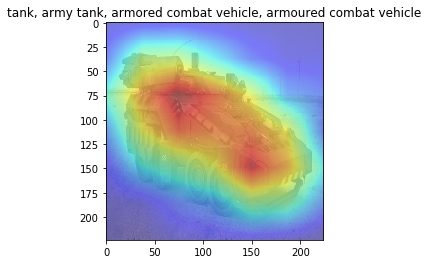

In [20]:
if __name__ == '__main__':
    ResNet_model, all_amp_layer_weights = get_ResNet()
    img_path = 'deftank.png'
    fig, ax = plt.subplots()
    CAM = plot_ResNet_CAM(img_path, ax, ResNet_model, all_amp_layer_weights)
    plt.show()